Import Required Libraries

In [1]:
# Install necessary libraries for the project.
# transformers is a library for state-of-the-art Natural Language Processing.
# accelerate helps with distributed training and mixed precision training.
!pip install transformers==4.41.0 -q
!pip install accelerate -q
!pip install huggingface-hub>=0.21.0 -q

# Import standard data manipulation and visualization libraries.
import pandas as pd # For data manipulation and analysis, especially with DataFrames.
import numpy as np # For numerical operations, especially array manipulations.
import matplotlib.pyplot as plt # For creating static, interactive, and animated visualizations.
import seaborn as sns # Based on matplotlib, provides a high-level interface for drawing attractive statistical graphics.

# Import machine learning utilities from scikit-learn.
from sklearn.model_selection import train_test_split # For splitting data into training and testing sets.
from sklearn.metrics import f1_score, classification_report, confusion_matrix # For evaluating model performance.

# Ignore warnings to keep the output clean.
import warnings
warnings.filterwarnings('ignore')

# Import PyTorch for deep learning.
import torch # The main PyTorch library.
from torch.utils.data import Dataset, DataLoader # Utilities for handling datasets and creating data loaders.

# Import components from the Hugging Face Transformers library.
from transformers import (
    DistilBertTokenizer, # Tokenizer for the DistilBERT model.
    DistilBertForSequenceClassification, # DistilBERT model specialized for sequence classification tasks.
    get_linear_schedule_with_warmup # Learning rate scheduler.
)

# Set random seeds for reproducibility across different runs and environments.
np.random.seed(42) # Seed for NumPy's random number generator.
torch.manual_seed(42) # Seed for PyTorch's CPU random number generator.
if torch.cuda.is_available(): # If a CUDA-enabled GPU is available.
    torch.cuda.manual_seed_all(42) # Seed for PyTorch's GPU random number generators.

# Determine the device to use for training (GPU if available, otherwise CPU).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}") # Print the device being used.
if torch.cuda.is_available():
    print(f" GPU Name: {torch.cuda.get_device_name(0)}") # Print the name of the GPU.
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB") # Print the total GPU memory.

Using device: cuda
 GPU Name: Tesla T4
GPU Memory: 14.74 GB


Load data

In [2]:
!pip install gdown
import gdown
import pandas as pd


train_url = 'https://drive.google.com/uc?id=1FicxTEnoS5laqo4zrgICDDFU7W_v8NMG'
train_output = '/content/train.csv'
gdown.download(train_url, train_output, quiet=False)
train_data = pd.read_csv('/content/train.csv')


test_url = 'https://drive.google.com/uc?id=1wThHU0FuVKow9owOP4qvWMuYb-PVYVLb'
test_output = '/content/test.csv'
gdown.download(test_url, test_output, quiet=False)
test_data = pd.read_csv('/content/test.csv')

train_data.head()

Downloading...
From (original): https://drive.google.com/uc?id=1FicxTEnoS5laqo4zrgICDDFU7W_v8NMG
From (redirected): https://drive.google.com/uc?id=1FicxTEnoS5laqo4zrgICDDFU7W_v8NMG&confirm=t&uuid=0c62ee26-c2ee-46c8-99e8-2d8004ab7ee3
To: /content/train.csv
100%|██████████| 596M/596M [00:05<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wThHU0FuVKow9owOP4qvWMuYb-PVYVLb
To: /content/test.csv
100%|██████████| 14.6M/14.6M [00:00<00:00, 58.1MB/s]


,fullText,asin,overall
0,Cannot Learn. I have an older URC-WR7 remote a...,0511189877,2
1,zero programming needed! Miracle!?. First tim...,0511189877,5
2,Works Good and programs easy.. Got them and on...,0511189877,4
3,Same as TWC remote. I got tired of the remote ...,0511189877,5
4,Good Quality Cord. After purchasing cheap cord...,0594459451,5


Rating Distribution:
overall
1     82950
2     56756
3     81239
4    156514
5    461485
Name: count, dtype: int64

Percentage Distribution:
overall
1     9.89
2     6.77
3     9.68
4    18.66
5    55.01
Name: count, dtype: float64


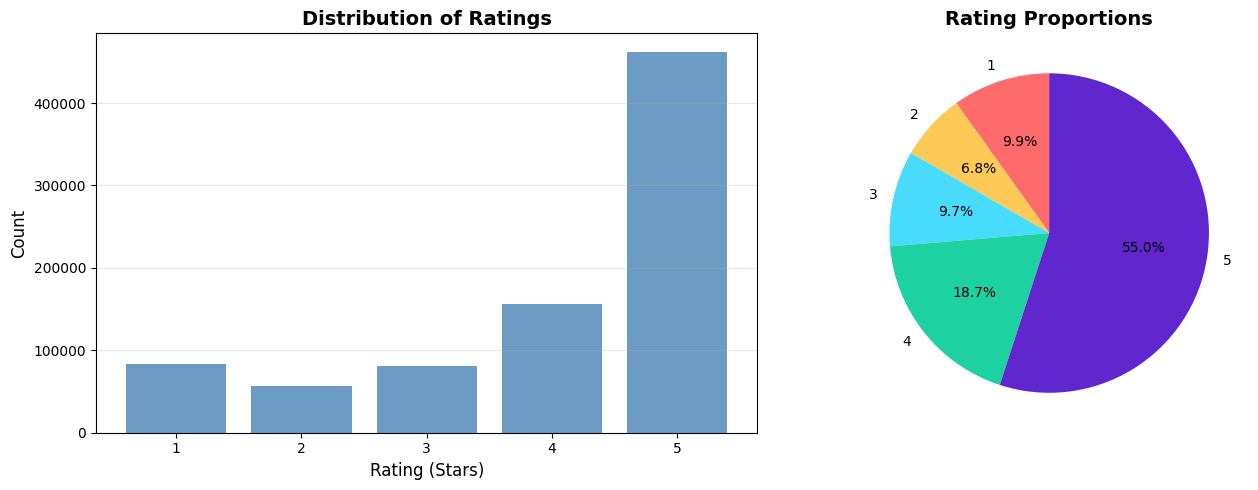


  Imbalance Ratio: 8.13
 Dataset is imbalanced. Consider using class weights or sampling techniques.


In [3]:
# Calculate class distribution
class_dist = train_data['overall'].value_counts().sort_index()

print("Rating Distribution:")
print(class_dist)
print(f"\nPercentage Distribution:")
print((class_dist / len(train_data) * 100).round(2))

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(class_dist.index, class_dist.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Rating (Stars)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1', '#5f27cd']
axes[1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Rating Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check if dataset is imbalanced
imbalance_ratio = class_dist.max() / class_dist.min()
print(f"\n  Imbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print(" Dataset is imbalanced. Consider using class weights or sampling techniques.")
else:
    print("Dataset is relatively balanced.")

Data Splitting and Class Distribution Verification

In [6]:
#  Initial 85/15 Split ---
# This creates our main training and a STABLE validation set.
X = train_data['fullText']
y = train_data['overall']
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y,
    test_size=0.15,  # 15% for validation
    random_state=42,
    stratify=y
)

X_train_full = X_train_full.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train_full = y_train_full.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)


# Convert labels to integers (0-4 instead of 1-5)
y_train_full = y_train_full - 1
y_val = y_val - 1



# We take 40% OF THE TRAINING DATA to speed things up.
# The validation set remains untouched.
X_train, _, y_train, _ = train_test_split(
    X_train_full, y_train_full,
    test_size=0.4,
    random_state=42,
    stratify=y_train_full
)

# Reset indices for the final training set
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print("--- Subset for Fast Training ---")
print(f"Subset training samples used for this run: {len(X_train):,}")
print(f"(This is {len(X_train)/len(X_train_full)*100:.1f}% of the full training set)")
print(f"Validation samples remain: {len(X_val):,}")



--- Subset for Fast Training ---
Subset training samples used for this run: 427,861
(This is 60.0% of the full training set)
Validation samples remain: 125,842


Custom Dataset Class for Sentiment Analysis

In [7]:
class SentimentDataset(Dataset):
    """
    A custom PyTorch Dataset class for handling text sentiment data.
    It tokenizes input texts and prepares them in a format suitable for
    Transformer models like DistilBERT.
    """

    def __init__(self, texts, labels, tokenizer, max_length=256):
        """
        Initializes the SentimentDataset.

        Args:
            texts (list or array): A list or array of input text strings.
            labels (list or array): A list or array of corresponding sentiment labels (integers).
            tokenizer (transformers.PreTrainedTokenizer): The tokenizer to use for encoding texts.
            max_length (int): The maximum sequence length for tokenization.
                              Texts longer than this will be truncated, and shorter ones will be padded.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset at the given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            dict: A dictionary containing:
                  - 'input_ids': PyTorch tensor of token IDs.
                  - 'attention_mask': PyTorch tensor of attention mask.
                  - 'labels': PyTorch tensor of the sentiment label.
        """
        # Ensure idx is within bounds and handle any index issues
        if idx >= len(self.texts):
            raise IndexError(f"Index {idx} is out of range for dataset of size {len(self.texts)}")

        text = str(self.texts.iloc[idx]) # Use iloc for positional indexing
        label = self.labels.iloc[idx]    # Use iloc for positional indexing

        # Tokenize and encode the text using the provided tokenizer.
        # This converts text into numerical input_ids and creates an attention mask.
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,      # Add [CLS] (start of sequence) and [SEP] (end of sequence) tokens.
            max_length=self.max_length,   # Pad/truncate sequences to this length.
            padding='max_length',         # Pad sequences to `max_length`.
            truncation=True,              # Truncate sequences that are longer than `max_length`.
            return_attention_mask=True,   # Generate an attention mask (1 for real tokens, 0 for padding).
            return_tensors='pt'           # Return PyTorch tensors.
        )

        # Return the processed sample in a dictionary format.
        # .flatten() is used to remove an extra dimension from the tensors (e.g., from [1, N] to [N]).
        return {
            'input_ids': encoding['input_ids'].flatten(),         # Token IDs for the input sequence.
            'attention_mask': encoding['attention_mask'].flatten(), # Mask to differentiate real tokens from padding.
            'labels': torch.tensor(label, dtype=torch.long)       # The sentiment label, converted to a PyTorch tensor.
        }

print("SentimentDataset class defined successfully")

SentimentDataset class defined successfully


Tokenizer Initialization and Dataset Creation


In [8]:
# Initialize the DistilBERT tokenizer.
# 'distilbert-base-uncased' specifies the pre-trained model variant.
# This tokenizer will be used to convert text into numerical token IDs
# and attention masks suitable for the DistilBERT model.
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


# Create instances of the custom SentimentDataset for training and validation data.
print("\n Creating dataset objects...")
MAX_LENGTH = 256  # Define the maximum sequence length for tokenization.
                  # This value should be chosen based on the typical length of your texts
                  # and the computational resources available.

# Create the training dataset instance.
# It uses the training texts (X_train), training labels (y_train),
# the initialized tokenizer, and the defined maximum length.
train_dataset = SentimentDataset(
    texts=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

# Create the validation dataset instance.
# Similar to the training dataset, but uses validation texts (X_val) and labels (y_val).
val_dataset = SentimentDataset(
    texts=X_val,
    labels=y_val,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

print(f" Training dataset created: {len(train_dataset):,} samples") # Confirm creation and size of training dataset.
print(f"Validation dataset created: {len(val_dataset):,} samples") # Confirm creation and size of validation dataset.

# Perform a quick test of the tokenization process on a sample text
# to ensure the tokenizer and MAX_LENGTH are working as expected.
sample_text = X_train.iloc[0] # Get the first text sample by its position.

sample_encoding = tokenizer.encode_plus(
    sample_text,
    max_length=MAX_LENGTH,
    truncation=True,
    return_tensors='pt'
)

print(f"\n Sample Tokenization Test:")
print(f"Original text length: {len(sample_text)} characters")
print(f"Tokenized length: {sample_encoding['input_ids'].shape[1]} tokens")
print(f"Sample tokens (first 10): {sample_encoding['input_ids'][0][:10].tolist()}")


 Creating dataset objects...
 Training dataset created: 427,861 samples
Validation dataset created: 125,842 samples

 Sample Tokenization Test:
Original text length: 876 characters
Tokenized length: 216 tokens
Sample tokens (first 10): [101, 2190, 4641, 3388, 2144, 1996, 29583, 17371, 1011, 1023]


Data Loaders for Efficient Batching

In [9]:
# Define parameters for the DataLoader.
BATCH_SIZE = 16   # Number of samples per batch. This affects training speed and memory usage.
NUM_WORKERS = 2   # Number of subprocesses to use for data loading.
                  # Set to 0 for single-process loading, which can be easier for debugging.
                  # A higher number can speed up data loading if your CPU is not a bottleneck.

# Create a DataLoader for the training dataset.
# This utility wraps the Dataset and provides an iterable over the dataset,
# allowing for efficient batching, shuffling, and multi-process data loading.
train_loader = DataLoader(
    train_dataset,        # The training dataset created earlier.
    batch_size=BATCH_SIZE,  # Specifies the batch size.
    shuffle=True,           # Shuffles the data at the beginning of each epoch for better generalization.
    num_workers=NUM_WORKERS,# Number of parallel processes for loading data.
    pin_memory=True         # If True, the DataLoader will copy Tensors into CUDA pinned memory
                            # before returning them. This can speed up data transfer to GPU.
)

# Create a DataLoader for the validation dataset.
# Validation data is typically not shuffled as the order does not impact model training.
val_loader = DataLoader(
    val_dataset,          # The validation dataset created earlier.
    batch_size=BATCH_SIZE,  # Specifies the batch size.
    shuffle=False,          # Data is not shuffled for validation.
    num_workers=NUM_WORKERS,# Number of parallel processes for loading data.
    pin_memory=True         # Pin memory for faster GPU transfer.
)

# Print the number of batches created for both training and validation.
# This gives an idea of how many iterations per epoch will occur.
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 26742
Validation batches: 7866


Initialize Model and Optimizer

In [10]:
from transformers import DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

NUM_LABELS = 5
LEARNING_RATE = 8e-6
WEIGHT_DECAY = 0.01
EPOCHS = 3
WARMUP_STEPS = 500


# Load pre-trained model with dropout for regularization
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=NUM_LABELS,
    dropout=0.2,
    attention_dropout=0.2
)
model.to(device)

# Freeze lower layers to reduce overfitting and speed up training
for name, param in model.named_parameters():
    # Freeze first four transformer layers
    if name.startswith('distilbert.transformer.layer.0.') or \
       name.startswith('distilbert.transformer.layer.1.') or \
       name.startswith('distilbert.transformer.layer.2.') or \
       name.startswith('distilbert.transformer.layer.3.'):
        param.requires_grad = False

# Initialize optimizer from torch.optim instead of transformers
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Calculate total training steps
total_steps = len(train_loader) * EPOCHS

# Initialize learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Model loaded: DistilBERT with {NUM_LABELS} output classes")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Dropout: 0.3, Attention dropout: 0.3")
print("First 4 transformer layers are frozen")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: DistilBERT with 5 output classes
Total training steps: 80226
Warmup steps: 500
Learning rate: 8e-06
Weight decay: 0.01
Dropout: 0.3, Attention dropout: 0.3
First 4 transformer layers are frozen


Define Training Function

In [11]:
from sklearn.metrics import f1_score # Import f1_score for evaluating classification performance.
import torch.nn as nn

# Define loss function with label smoothing for better generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def train_epoch(model, data_loader, optimizer, scheduler, device):
    """
    Performs one full training epoch over the dataset.

    Args:
        model (torch.nn.Module): The neural network model to train.
        data_loader (torch.utils.data.DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): The optimizer used for updating model weights.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        device (torch.device): The device (CPU or GPU) to perform computations on.

    Returns:
        tuple: A tuple containing the average loss, accuracy, and F1-score for the epoch.
    """

    model.train() # Set the model to training mode. This enables dropout and batch normalization.
    total_loss = 0 # Initialize total loss for the epoch.
    correct_predictions = 0 # Initialize counter for correct predictions.
    all_predictions = [] # List to store all predictions made during the epoch.
    all_labels = []      # List to store all true labels during the epoch.

    # Loop through batches provided by the data_loader.
    for batch in data_loader:
        # Move batch data to the specified device (GPU/CPU).
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the gradients of the optimizer. This is important to prevent
        # gradients from accumulating across batches.
        optimizer.zero_grad()

        # Perform a forward pass: Feed the inputs to the model.
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits # Extract the raw predictions (logits) before softmax.

        # Use custom loss with label smoothing instead of model's internal loss
        loss = criterion(logits, labels)

        # Perform a backward pass: Compute gradients of the loss with respect to model parameters.
        loss.backward()

        # Gradient clipping: Clip gradients to a maximum norm to prevent "exploding gradients",
        # which can make training unstable.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update model weights based on the computed gradients and learning rate.
        optimizer.step()
        # Update the learning rate according to the scheduler's policy.
        scheduler.step()

        # Accumulate metrics for the current batch.
        total_loss += loss.item() # Add batch loss to total loss.
        # Get the predicted class by finding the index of the maximum logit.
        predictions = torch.argmax(logits, dim=1)
        # Count correct predictions in the current batch.
        correct_predictions += torch.sum(predictions == labels)

        # Store predictions and true labels (moved to CPU for NumPy compatibility)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate and return epoch-level metrics after processing all batches.
    avg_loss = total_loss / len(data_loader) # Average loss across all batches.
    accuracy = correct_predictions.double() / len(data_loader.dataset) # Overall accuracy for the epoch.
    # Calculate F1-score. 'micro' average is used for multi-class classification,
    # it counts total true positives, false negatives, and false positives.
    f1 = f1_score(all_labels, all_predictions, average='micro')

    return avg_loss, accuracy.item(), f1

Define Evaluation Function

In [12]:
import torch.nn as nn

# Define evaluation loss function (without label smoothing for evaluation)
eval_criterion = nn.CrossEntropyLoss()

def evaluate_model(model, data_loader, device):
    """
    Evaluates the model's performance on a given dataset (validation or test set).

    Args:
        model (torch.nn.Module): The neural network model to evaluate.
        data_loader (torch.utils.data.DataLoader): DataLoader for the evaluation data.
        device (torch.device): The device (CPU or GPU) to perform computations on.

    Returns:
        tuple: A tuple containing the average loss, accuracy, F1-score,
               all predicted labels, and all true labels for the evaluation set.
    """

    model.eval() # Set the model to evaluation mode. This disables dropout and batch normalization.
    total_loss = 0 # Initialize total loss.
    correct_predictions = 0 # Initialize counter for correct predictions.
    all_predictions = [] # List to store all predictions.
    all_labels = []      # List to store all true labels.

    # Disable gradient calculations during evaluation to save memory and speed up computation.
    with torch.no_grad():
        # Loop through batches provided by the data_loader.
        for batch in data_loader:
            # Move batch data to the specified device (GPU/CPU).
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Perform a forward pass: Feed the inputs to the model.
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits # Extract the raw predictions (logits).

            # Use standard CrossEntropyLoss for evaluation (no label smoothing)
            loss = eval_criterion(logits, labels)

            # Accumulate metrics for the current batch.
            total_loss += loss.item() # Add batch loss to total loss.
            # Get the predicted class by finding the index of the maximum logit.
            predictions = torch.argmax(logits, dim=1)
            # Count correct predictions in the current batch.
            correct_predictions += torch.sum(predictions == labels)

            # Store predictions and true labels (moved to CPU for NumPy compatibility).
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate and return epoch-level metrics after processing all batches.
    avg_loss = total_loss / len(data_loader) # Average loss across all batches.
    accuracy = correct_predictions.double() / len(data_loader.dataset) # Overall accuracy.
    # Calculate F1-score. 'micro' average is used.
    f1 = f1_score(all_labels, all_predictions, average='micro')

    # Return all metrics, plus the collected predictions and true labels for further analysis.
    return avg_loss, accuracy.item(), f1, all_predictions, all_labels

In [13]:
print("Checking data integrity...")
print(f"Training labels unique values: {sorted(y_train.unique())}")
print(f"Validation labels unique values: {sorted(y_val.unique())}")
print(f"Training labels dtype: {y_train.dtype}")
print(f"Validation labels dtype: {y_val.dtype}")



Checking data integrity...
Training labels unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Validation labels unique values: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Training labels dtype: int64
Validation labels dtype: int64


Training Loop

In [14]:
import time
import datetime
import os
import collections
import torch # We need torch for the clip_grad_norm_ function

# A helper function for formatting elapsed time.
def format_time(elapsed):
    """
    Takes a time in seconds and returns a string in the format hh:mm:ss.
    """
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# --- Main Training Loop ---

# Gradient accumulation parameters
ACCUM_STEPS = 2  # Effective batch size becomes 32 (16 * 2)
PATIENCE = 2  # Early stopping patience
no_improve = 0  # Counter for early stopping

history = collections.defaultdict(list)
best_f1 = 0.0
OUTPUT_DIR = './model_save/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

for epoch_i in range(0, EPOCHS):

    # ========================================
    #               Training
    # ========================================

    print("")
    print(f'======== Epoch {epoch_i + 1} / {EPOCHS} ========')
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    # Get the total number of batches for this epoch
    total_steps = len(train_loader)

    for step, batch in enumerate(train_loader):

        # --- MODIFICATION START ---
        # Progress update every 500 batches.
        if step % 500 == 0 and not step == 0:

            # Calculate elapsed time in seconds.
            elapsed_secs = time.time() - t0

            # Calculate speed: steps per second.
            # Add 1 to step to avoid division by zero at the start.
            steps_per_sec = step / elapsed_secs

            # Calculate estimated time remaining.
            # (Total steps - current step) / speed
            remaining_steps = total_steps - step
            est_remaining_secs = remaining_steps / steps_per_sec

            # Format times as hh:mm:ss strings.
            elapsed_formatted = format_time(elapsed_secs)
            est_remaining_formatted = format_time(est_remaining_secs)

            # Print the progress report including the estimated time.
            print(f'  Batch {step:>5,}  of  {total_steps:>5,}.   Elapsed: {elapsed_formatted}.   Remaining Est: {est_remaining_formatted}.')

        # --- MODIFICATION END ---

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        outputs = model(b_input_ids,
                        attention_mask=b_attention_mask)

        logits = outputs.logits

        # Use custom loss with label smoothing (from cell 16)
        loss = criterion(logits, b_labels)

        # Gradient accumulation: divide loss by accumulation steps
        (loss / ACCUM_STEPS).backward()

        total_train_loss += loss.item()

        # Only update weights after accumulating gradients
        if (step + 1) % ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    avg_train_loss = total_train_loss / total_steps
    training_time = format_time(time.time() - t0)

    print(f"\n  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training epoch took: {training_time}")

    # ========================================
    #               Validation
    # ========================================

    print("\nRunning Validation...")

    t0 = time.time()

    val_loss, val_acc, val_f1, _, _ = evaluate_model(
        model,
        val_loader,
        device
    )

    validation_time = format_time(time.time() - t0)

    print(f"  Validation Loss: {val_loss:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Validation F1 (Micro): {val_f1:.4f}")
    print(f"  Validation took: {validation_time}")

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        no_improve = 0
        model.save_pretrained(OUTPUT_DIR)
        tokenizer.save_pretrained(OUTPUT_DIR)
        print(f"\n  >>> New best model saved with F1-Score: {best_f1:.4f} <<<")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"\n  >>> Early stopping triggered! No improvement for {PATIENCE} epochs. <<<")
            break

print("\n" + "="*30)
print("Training complete!")
print(f"Best validation F1-Score (Micro) achieved: {best_f1:.4f}")



======== Epoch 1 / 3 ========
Training...
  Batch   500  of  26,742.   Elapsed: 0:02:15.   Remaining Est: 1:58:28.
  Batch 1,000  of  26,742.   Elapsed: 0:04:33.   Remaining Est: 1:57:07.
  Batch 1,500  of  26,742.   Elapsed: 0:06:51.   Remaining Est: 1:55:14.
  Batch 2,000  of  26,742.   Elapsed: 0:09:09.   Remaining Est: 1:53:07.
  Batch 2,500  of  26,742.   Elapsed: 0:11:27.   Remaining Est: 1:50:57.
  Batch 3,000  of  26,742.   Elapsed: 0:13:44.   Remaining Est: 1:48:44.
  Batch 3,500  of  26,742.   Elapsed: 0:16:02.   Remaining Est: 1:46:28.
  Batch 4,000  of  26,742.   Elapsed: 0:18:19.   Remaining Est: 1:44:11.
  Batch 4,500  of  26,742.   Elapsed: 0:20:37.   Remaining Est: 1:41:55.
  Batch 5,000  of  26,742.   Elapsed: 0:22:55.   Remaining Est: 1:39:39.
  Batch 5,500  of  26,742.   Elapsed: 0:25:13.   Remaining Est: 1:37:23.
  Batch 6,000  of  26,742.   Elapsed: 0:27:31.   Remaining Est: 1:35:07.
  Batch 6,500  of  26,742.   Elapsed: 0:29:48.   Remaining Est: 1:32:49.
  Batch 

KeyboardInterrupt: 

In [16]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR)
tokenizer = AutoTokenizer.from_pretrained(OUTPUT_DIR)

model.to(device)
print("✅ Model restored from last checkpoint and ready to use!")


✅ Model restored from last checkpoint and ready to use!


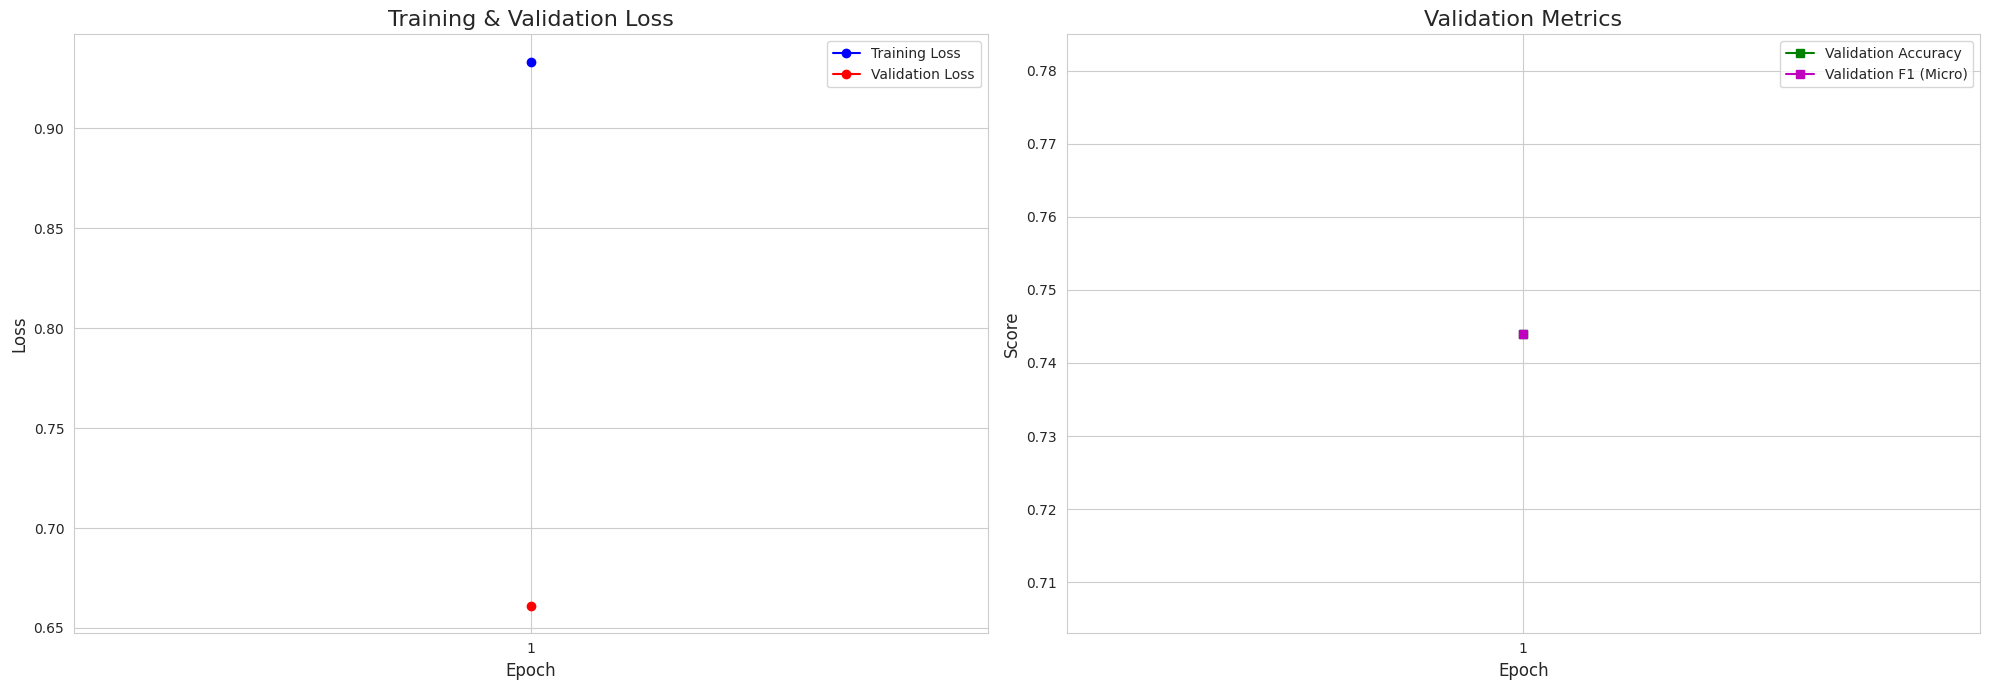

In [17]:
def plot_training_history(history):

    sns.set_style("whitegrid")


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))


    ax1.plot(history['train_loss'], 'b-o', label='Training Loss')
    ax1.plot(history['val_loss'], 'r-o', label='Validation Loss')
    ax1.set_title('Training & Validation Loss', fontsize=16)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend()

    ax1.set_xticks(range(len(history['train_loss'])))
    ax1.set_xticklabels(range(1, len(history['train_loss']) + 1))



    ax2.plot(history['val_acc'], 'g-s', label='Validation Accuracy')
    ax2.plot(history['val_f1'], 'm-s', label='Validation F1 (Micro)')
    ax2.set_title('Validation Metrics', fontsize=16)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)

    ax2.legend()

    ax2.set_xticks(range(len(history['val_f1'])))
    ax2.set_xticklabels(range(1, len(history['val_f1']) + 1))


    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [18]:
test_data.head()

,fullText,asin
0,The prize for most useless invention of all ti...,B006Z394GM
1,MELTED MOLEX CONNECTOR. One of the molex conne...,B005BE058W
2,Bricked on the regular. Remote constantly disc...,B01DA0YCNC
3,DO NOT BUY!!!. I purchased this 4 year protect...,B00FBJ4KYC
4,Nightmare - don't buy. I bought one of these a...,B00P7G82TS


In [19]:
# Initial Setup and Configuration
BATCH_SIZE = 16
MAX_LEN = 256
OUTPUT_DIR = './model_save/'  # The directory where the best model was saved
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load the Best Fine-Tuned Model and Tokenizer ---
print("Loading the best fine-tuned model from disk...")
try:
    # Load the tokenizer from the saved directory
    tokenizer = DistilBertTokenizer.from_pretrained(OUTPUT_DIR)
    # Load the model from the saved directory
    model = DistilBertForSequenceClassification.from_pretrained(OUTPUT_DIR)
    # Move the model to the selected device (GPU or CPU)
    model.to(device)
    print("Model and Tokenizer loaded successfully!")
except OSError:
    print(" Error: Could not find the model/tokenizer in the specified directory.")
    print(f"Please make sure the path '{OUTPUT_DIR}' is correct and contains the saved model files.")
    # You might want to stop execution if the model can't be loaded, e.g., by uncommenting 'raise'
    # raise

# Prepare the Test Data
print("\nPreparing test data...")
# Read the test CSV file
test_data = pd.read_csv('test.csv')

# Custom Dataset class for the test set (which has no labels)
class SentimentTestDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,  # We don't need token type ids for DistilBERT
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        # Return a dictionary of tensors
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Create an instance of the test dataset using the 'fullText' column
test_dataset = SentimentTestDataset(
    texts=test_data['fullText'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create a DataLoader for the test set
# shuffle=False is crucial to maintain the original order for the submission file.
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Test data is ready.")


# Prediction Loop
print("\nRunning predictions on the test set...")
model.eval()

all_predictions = []
total_batches = len(test_loader) # Calculate the total number of batches

# Loop through the test data batch by batch
for i, batch in enumerate(test_loader):
    # Move batch tensors to the selected device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    # Disable gradient calculation for faster inference and lower memory usage
    with torch.no_grad():
        # Get model outputs (logits)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Find the class with the highest probability (argmax) and move to CPU
    predictions = np.argmax(logits.detach().cpu().numpy(), axis=1)
    # Append the batch predictions to our master list
    all_predictions.extend(predictions)

    # Print progress every 100 batches to show that the script is running
    if (i + 1) % 100 == 0:
        print(f"  Processed batch {i + 1} of {total_batches}")

print("Prediction complete!")


# Create the Final Submission File ---
print("\nCreating the submission file...")

# Crucial Conversion Step: The model outputs labels from 0-4, but the competition
# requires scores from 1-5. We must add 1 to each prediction.
final_predictions_for_submission = [p + 1 for p in all_predictions]

# Create a DataFrame in the required format (a single 'predicted' column)
submission_df = pd.DataFrame({'predicted': final_predictions_for_submission})

# Save the DataFrame to a CSV file without the index column
submission_df.to_csv('q2_submission.csv', index=False)

print("\n Success! File 'q2_submission.csv' has been created.")
print("Here's a sample of submission file:")
print(submission_df.head())


Loading the best fine-tuned model from disk...
Model and Tokenizer loaded successfully!

Preparing test data...
Test data is ready.

Running predictions on the test set...
  Processed batch 100 of 1250
  Processed batch 200 of 1250
  Processed batch 300 of 1250
  Processed batch 400 of 1250
  Processed batch 500 of 1250
  Processed batch 600 of 1250
  Processed batch 700 of 1250
  Processed batch 800 of 1250
  Processed batch 900 of 1250
  Processed batch 1000 of 1250
  Processed batch 1100 of 1250
  Processed batch 1200 of 1250
Prediction complete!

Creating the submission file...

 Success! File 'q2_submission.csv' has been created.
Here's a sample of submission file:
   predicted
0          1
1          1
2          1
3          1
4          1


In [20]:
submission_df.value_counts()

,count
predicted,
5,5514
1,5234
3,3949
4,3366
2,1937


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
submission_df.to_csv("/content/drive/MyDrive/project2/q2_submission.csv")

In [23]:
submission_df.head()

,predicted
0,1
1,1
2,1
3,1
4,1


In [24]:
submission_df.shape

(20000, 1)